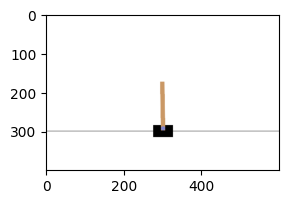

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True
        
        #没坚持到最后,扣分
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [ ]:
'''
* 作用: 這裡定義了兩個神經網路，這是與前一個 Notebook 最大的不同。
* `model_action`: 策略網路 (Policy Network)。和之前一樣，它的作用是輸入狀態，輸出每個動作的機率。
* `model_baseline`: 價值網路 (Value
    Network)。這是一個全新的模型，它的作用是輸入狀態，輸出一個單一的數值，這個數值代表對當前狀態的價值評估
    (Value)。它試圖預測從當前狀態開始，預期能獲得多少未來總獎勵。
'''


import torch

#定义模型,计算每个动作的概率
model_action = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
    torch.nn.Softmax(dim=1),
)

#基线模型,评估state的价值
model_baseline = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_action, model_baseline

(Sequential(
   (0): Linear(in_features=4, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=2, bias=True)
   (5): Softmax(dim=1)
 ),
 Sequential(
   (0): Linear(in_features=4, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=1, bias=True)
 ))

In [4]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    state = []
    action = []
    reward = []

    s = env.reset()
    o = False
    while not o:
        #根据概率采样
        prob = model_action(torch.FloatTensor(s).reshape(1, 4))[0].tolist()
        a = random.choices(range(2), weights=prob, k=1)[0]

        ns, r, o = env.step(a)

        state.append(s)
        action.append(a)
        reward.append(r)

        s = ns

        if show:
            display.clear_output(wait=True)
            env.show()

    state = torch.FloatTensor(state).reshape(-1, 4)
    action = torch.LongTensor(action).reshape(-1, 1)
    reward = torch.FloatTensor(reward).reshape(-1, 1)

    return state, action, reward, reward.sum().item()


state, action, reward, reward_sum = play()

reward_sum

-988.0

In [ ]:
'''
 * 作用: 因為有兩個模型，所以需要建立兩個獨立的優化器來分別更新它們的權重。
'''

optimizer_action = torch.optim.Adam(model_action.parameters(), lr=5e-3)
optimizer_baseline = torch.optim.Adam(model_baseline.parameters(), lr=5e-4)

In [ ]:
'''
這個函式與 01_reinforce.ipynb 中的價值計算邏輯完全相同，都是用蒙地卡羅法計算從每一步開始的未來總折扣獎勵。我們仍然稱這個為 value。
'''

def get_value(reward):
    #计算当前state的价值,其实就是Q(state,action),这里是用蒙特卡洛法估计的
    value = []
    for i in range(len(reward)):
        s = 0
        for j in range(i, len(reward)):
            s += reward[j] * 0.99**(j - i)
        value.append(s)

    return torch.FloatTensor(value).reshape(-1, 1)


value = get_value(reward)

value.shape

torch.Size([13, 1])

In [ ]:
'''
* 作用: 專門用來訓練 model_baseline (價值網路)。
* 核心邏輯:
    1. baseline = model_baseline(state): 將遊戲中實際經過的狀態 state 輸入價值網路，得到模型對這些狀態的價值預測 baseline。
    2. loss = mse_loss(baseline, value): 計算均方誤差 (MSE)。這裡的 value 是我們用蒙地卡羅法算出的「真實」未來總獎勵。所以，這個 loss
        的目標就是讓 model_baseline 的預測越來越接近「真實」的價值。
    3. `return baseline.detach()`: 訓練完後，返回不帶梯度的 baseline 值。我們在下一步訓練策略網路時只需要這個數值，而不需要它的梯度。

'''


#训练baseline模型
def train_baseline(state, value):
    baseline = model_baseline(state)

    loss = torch.nn.functional.mse_loss(baseline, value)
    loss.backward()
    optimizer_baseline.step()
    optimizer_baseline.zero_grad()

    return baseline.detach()


baseline = train_baseline(state, value)

baseline.shape

torch.Size([13, 1])

In [ ]:
'''
* 作用: 訓練 model_action (策略網路)。
* 核心改動:
    * 原本的 Loss 是 log(prob) * value。
    * 現在的 Loss 變成了 log(prob) * (value - baseline)。
    * value - baseline 這個量被稱為 Advantage (優勢)，寫作 $A(s, a)$。
* 為什麼要這樣做？
    * 假設在一局好遊戲中，所有 value 都是正的。在沒有 baseline
        的情況下，所有動作都會被「鼓勵」。但事實上，這局好遊戲中可能有些動作是「比較差」的，只是運氣好。
    * 引入 baseline 後，value - baseline 就變成了一個相對值。
        * 如果 value > baseline (實際得到的比預期的好)，Advantage 為正，這個動作被鼓勵。
        * 如果 value < baseline (實際得到的比預期的差)，Advantage 為負，這個動作被抑制 (即使 value 本身是正的！)。
    * 這使得獎勵訊號更清晰，大大降低了訓練過程中的變異數，讓模型收斂得更穩定、更快速。
'''

#训练action模型
def train_action(state, action, value, baseline):
    #重新计算动作的概率
    prob = model_action(state).gather(dim=1, index=action)

    #求Q最大的导函数 -> partial value / partial action
    #注意这里的Q使用前要去基线,这也是baseline模型存在的意义
    prob = (prob + 1e-8).log() * (value - baseline)
    for i in range(len(prob)):
        prob[i] = prob[i] * 0.99**i
    loss = -prob.mean()

    loss.backward()
    optimizer_action.step()
    optimizer_action.zero_grad()

    return loss.item()


train_action(state, action, value, baseline)

-597.4337158203125

In [9]:
#训练
def train():
    model_action.train()
    model_baseline.train()

    #训练N局
    for epoch in range(1000):

        #一个epoch最少玩N步
        steps = 0
        while steps < 200:

            #玩一局游戏,得到数据
            state, action, reward, _ = play()
            steps += len(state)

            #训练两个模型
            value = get_value(reward)
            baseline = train_baseline(state, value)
            loss = train_action(state, action, value, baseline)

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, loss, test_result)


train()

0 -364.41156005859375 -965.55
100 15.765361785888672 147.95
200 15.636146545410156 200.0
300 14.664276123046875 200.0
400 15.47754192352295 147.05
500 12.18871784210205 94.2
600 13.042450904846191 200.0
700 14.563920021057129 200.0
800 12.581521034240723 200.0
900 10.215791702270508 200.0


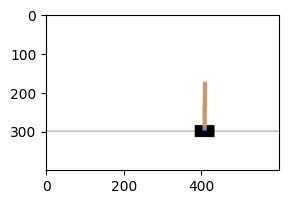

200.0

In [10]:
play(True)[-1]